First, we install the necessary software package.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# In Colab:
!pip install --index-url https://test.pypi.org/simple/ \
            --extra-index-url https://pypi.org/simple \
            "scikit-misc==0.2.0rc1"


Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install -U https://github.com/PythonOT/POT/archive/master.zip # with --user for user install (no root)
!pip install pykeops
!pip install geomloss
!pip install muon
!pip install gprofiler-official

!pip install scanpy
!pip install muon
!pip install pyranges

     | 3.1 MB 16.0 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for POT: filename=pot-0.9.7.dev0-cp311-cp311-linux_x86_64.whl size=1366862 sha256=5a3eb65f0735a9f6d7f53d31a519fac40ec0496c69b24c821c87f3726c2d978c
  Stored in directory: /tmp/pip-ephem-wheel-cache-9mw6bwr5/wheels/fc/b3/69/deb9c12f26c4c311bb43fab28b37c7a1faa3c089b07eea1ceb
Successfully built POT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.2/552.2 kB 22.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 39.7 MB/s eta 0:00:00
  Create

In [ ]:
pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 245.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import Grotia_utils
importlib.reload(Grotia_utils)
from Grotia_utils import (
   load_results,interpret_embedding_top_genes,plot_top_genes_by_dimension_sequential,
   write_all_peaks_to_bed,bed_to_fasta,r
   un_gimme_motifs_with_genome,
   run_pathway_analysis_top_genes
)


As our interpretability framework relies on the learned projection matrix and the corresponding kernel matrix, we first load or compute both from the data.

In [ ]:
import muon as mu
mdata = mu.read_h5mu("/content/drive/MyDrive/pbmc10X.h5mu.gz")

sc.pp.filter_cells(mdata["rna"], min_genes=100)
sc.pp.filter_genes(mdata["rna"], min_cells=20)

sc.pp.filter_cells(mdata["atac"], min_genes=100)
# we're actually filtering peaks here
sc.pp.filter_genes(mdata["atac"], min_cells=20)
mdata.update()


mdata["rna"].layers["counts"] = mdata["rna"].X.copy()

# Log-normalize the scRNA counts
sc.pp.normalize_total(mdata["rna"], target_sum=10000.)
sc.pp.log1p(mdata["rna"])

# Since we use both raw and normalized gene counts in our autoencoder it makes sense to select highly variable genes based on both criteria
raw_hvg = sc.pp.highly_variable_genes(mdata["rna"], layer="counts", n_top_genes=3000, subset=False, inplace=False,
                                     flavor="seurat_v3")["highly_variable"].values
norm_hvg = sc.pp.highly_variable_genes(mdata["rna"], n_top_genes=3000, subset=False,
                                       inplace=False)["highly_variable"].values
mdata.mod["rna"] = mdata["rna"][:, np.logical_or(raw_hvg, norm_hvg)].copy()

# Perform PCA on the selected genes
sc.tl.pca(mdata["rna"], n_comps=50, zero_center=None)
mu.atac.pp.tfidf(mdata["atac"], log_tf=True, log_idf=True)
sc.tl.pca(mdata["atac"], n_comps=50, zero_center=None)

X_normalized = (mdata["rna"].obsm['X_pca'] )
y_normalized = (mdata["atac"].obsm['X_pca'] )
gamma_x = calculate_gamma(X_normalized)
gamma_y = calculate_gamma(y_normalized)
# celltype_array = np.array(mdata.obs['celltype'][:4000])


kernel_X_original= rbf_kernel(X_normalized,gamma_x)
transformer = KernelCenterer().fit(kernel_X_original)
kernel_X_center = transformer.transform(kernel_X_original)

kernel_y_original= rbf_kernel(y_normalized,gamma_y)
transformer = KernelCenterer().fit(kernel_y_original)
kernel_y_center = transformer.transform(kernel_y_original)


/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


We load the projection matrix from both domains (RNA and ATAC), together with the corresponding optimal transport (OT) map.

In [ ]:
import numpy as np

# Example usage:
mapped_K1, mapped_K2, ot_plan, alpha, beta = load_results(
    path_mappedK1="/content/drive/MyDrive/mappedK1.npy",
    path_mappedK2="/content/drive/MyDrive/mappedK2.npy",
    path_otplan="/content/drive/MyDrive/ot_plan.npy",
    path_alpha="/content/drive/MyDrive/alpha.npy",
    path_beta="/content/drive/MyDrive/beta.npy"
)

print("Loaded shapes:")
print("  mapped_K1:", mapped_K1.shape)
print("  mapped_K2:", mapped_K2.shape)
print("  ot_plan:", ot_plan.shape)
print("  alpha:", alpha.shape)
print("  beta:", beta.shape)

Loaded shapes:
  mapped_K1: (9378, 8)
  mapped_K2: (9378, 8)
  ot_plan: (9378, 9378)
  alpha: (9378, 8)
  beta: (9378, 8)


To interpret each latent embedding dimension in terms of genes, we apply interpret_embedding_top_genes using the learned per-cell coefficients (alpha), the centered cell–cell kernel (K_centered), and the kernel scale parameter (gamma). The function computes sensitivities in PCA space, propagates them back to gene space via the PCA loadings (adata.varm["PCs"]) using the chain rule, and ranks genes by the mean absolute sensitivity per dimension. We report the top-
𝑘
k genes for each latent dimension as putative drivers of the corresponding embedding axis.

In [ ]:

avg_abs_sens_genes, top_genes_by_dim = interpret_embedding_top_genes(
    adata=mdata["rna"],
    alpha=alpha,
    K_centered=kernel_X_center,
    gamma=gamma_x,
    pca_key="X_pca",
    pcs_key="PCs",
    top_k=100,
    print_top=False  # set True to print
)

print("Top genes per dimension (names only):")
for d, genes in top_genes_by_dim.items():
    print(f"Dim {d}: {genes[:10]} ...")  # preview


Top genes per dimension (names only):
Dim 0: ['LYZ', 'ZEB2', 'PLXDC2', 'SLC8A1', 'LYN', 'VCAN', 'CD74', 'SAT1', 'AOAH', 'HLA-DRA'] ...
Dim 1: ['ZEB2', 'LYZ', 'AOAH', 'PLXDC2', 'CD74', 'SLC8A1', 'LEF1', 'HLA-DRA', 'BCL11B', 'LRMDA'] ...
Dim 2: ['GNLY', 'CCL5', 'LEF1', 'BACH2', 'NKG7', 'MAML2', 'PDE3B', 'CAMK4', 'ZEB2', 'SERINC5'] ...
Dim 3: ['VCAN', 'S100A4', 'MTSS1', 'HLA-DPA1', 'IFITM3', 'ITGB1', 'COTL1', 'BACH2', 'S100A11', 'MAML2'] ...
Dim 4: ['VCAN', 'ANXA1', 'PLXDC2', 'BACH2', 'LRMDA', 'PLCB1', 'NEAT1', 'LEF1', 'DPYD', 'CD36'] ...
Dim 5: ['TCF7L2', 'FCGR3A', 'MTSS1', 'CDKN1C', 'IFITM3', 'AFF3', 'AIF1', 'SERPINA1', 'WARS', 'MS4A7'] ...
Dim 6: ['THEMIS', 'TSHZ2', 'FHIT', 'CD8B', 'ANK3', 'CD8A', 'NELL2', 'AC139720.1', 'LYZ', 'IL32'] ...
Dim 7: ['SLC2A3', 'S100A9', 'S100A8', 'CAMK2D', 'HLA-DRA', 'ANK3', 'PDE4D', 'HLA-DQA1', 'CD83', 'AOAH'] ...


We then visualize the per-dimension gene importance scores using plot_top_genes_by_dimension_sequential, which produces a heatmap of the top-
𝑘
k genes for each latent dimension and highlights each dimension’s top genes with a red bounding box.

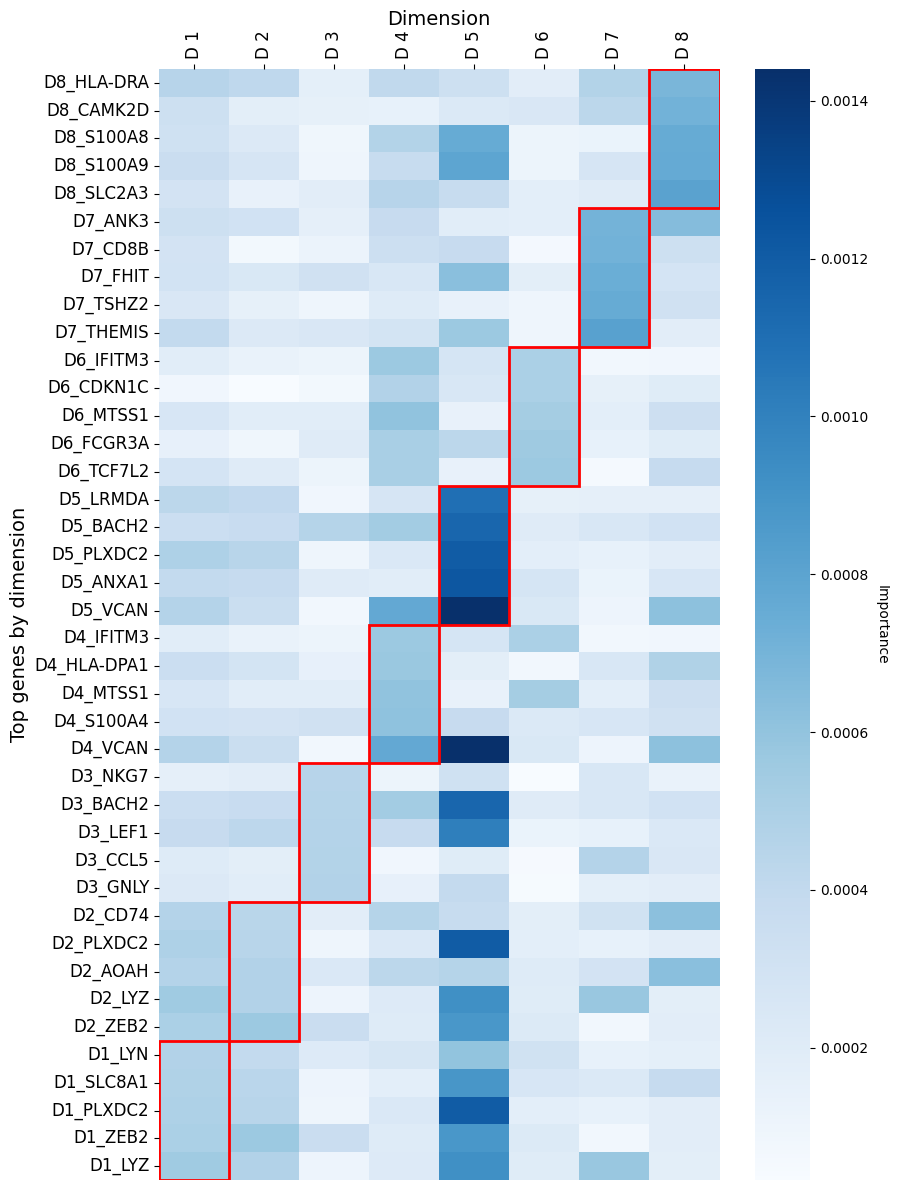

In [ ]:

# Example usage:
plot_top_genes_by_dimension_sequential(avg_abs_sens_genes, mdata["rna"].var_names, top_k=5)


For the RNA modality, we perform pathway/GO enrichment analysis on the top genes for each latent dimension by running run_pathway_analysis_top_genes(top_genes_by_dim), which queries g:Profiler and returns per-dimension enrichment results (GO/KEGG/Reactome).

In [ ]:

enrichment_results_by_dim = run_pathway_analysis_top_genes(top_genes_by_dim)



--- Pathway Analysis for Dimension 0 ---
  source      native                                            name  \
0  GO:BP  GO:0002682             regulation of immune system process   
1  GO:BP  GO:0002376                           immune system process   
2  GO:BP  GO:0006955                                 immune response   
3  GO:BP  GO:0002684    positive regulation of immune system process   
4  GO:BP  GO:0051239  regulation of multicellular organismal process   

        p_value  significant  \
0  1.835380e-21         True   
1  1.037405e-20         True   
2  1.334316e-17         True   
3  2.626855e-17         True   
4  3.723644e-17         True   

                                         description  term_size  query_size  \
0  "Any process that modulates the frequency, rat...       1581         180   
1  "Any process involved in the development or fu...       2871         180   
2  "Any immune system process that functions in t...       2070         180   
3  "Any process 

Similarly, we apply the same analysis to the ATAC modality, using the appropriate libraries for chromatin accessibility data.

In [ ]:
avg_abs_sens_peaks, top_peaks_by_dim = interpret_embedding_top_genes(
    adata=mdata["atac"],
    alpha=beta,
    K_centered=kernel_y_center,
    gamma=gamma_y,
    pca_key="X_pca",
    pcs_key="PCs",
    top_k=1000,
    print_top=False  # set True to print
)

print("Top genes per dimension (names only):")
for d, genes in top_peaks_by_dim.items():
    print(f"Dim {d}: {genes[:10]} ...")  # preview


Top genes per dimension (names only):
Dim 0: ['chr6:44058491-44059286', 'chr2:1822751-1823661', 'chr2:86785399-86785901', 'chr12:10554267-10555223', 'chr2:86825765-86826652', 'chr20:50274666-50275585', 'chr6:44064154-44065076', 'chr19:47388776-47389731', 'chr9:134371498-134372350', 'chr19:28632185-28632982'] ...
Dim 1: ['chr14:105817767-105818662', 'chr14:64235492-64236400', 'chr6:44058491-44059286', 'chr16:88069188-88070082', 'chr10:48671241-48672145', 'chr22:41935938-41936849', 'chr1:178605679-178606546', 'chr6:88141509-88142457', 'chr3:13110453-13111334', 'chr20:43681796-43682628'] ...
Dim 2: ['chr12:52566610-52567512', 'chr17:36066303-36067216', 'chr4:8409189-8410117', 'chr12:121557431-121558344', 'chr14:24633897-24634800', 'chr7:121530228-121531217', 'chr1:202197397-202198309', 'chr20:20215859-20216748', 'chr2:231425721-231426641', 'chr1:25065672-25066545'] ...
Dim 3: ['chr16:83744246-83745164', 'chr5:54774499-54775391', 'chr10:113169759-113170685', 'chr1:241964511-241965409', 'ch

In [ ]:
!python --version


Python 3.11.13


In [ ]:
!pip install gimmemotifs gprofiler
!apt-get install bedtools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 143.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 87.2 

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 2 not upgraded.
Need to get 563 kB of archives.
After this operation, 1,548 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 bedtools amd64 2.30.0+dfsg-2ubuntu0.1 [563 kB]
Fetched 563 kB in 0s (3,134 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 122124 files and directories currently installed.)
Preparing to unpack .../bedtools_2.30.0+dfsg-2ubuntu0.1_amd64.deb ...
Unpacking bedtools (2.30.0+dfsg-2ubuntu0.1) ...
Setting up bedtools (2.30.0+dfsg-2ubuntu0.1) ...


In [ ]:
!pip install "pandas<2.0"  # e.g., 1.5.3
# then rerun your command


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 218.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anndata 0.12.3 requires pandas!=2.1.2,>=2.1.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.


In [ ]:
pip install pyranges

We download the hg38 reference genome FASTA (hg38.fa.gz) from UCSC because ATAC-seq peaks are defined by genomic coordinates, and downstream analyses such as peak annotation, motif enrichment, and peak-to-gene mapping require access to the underlying DNA sequence.

In [ ]:
!mkdir -p genome_data


In [ ]:
cd genome_data


/content/genome_data


In [ ]:
!wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz

--2025-10-21 12:55:06--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘hg38.fa.gz’

hg38.fa.gz          100%[===================>] 938.09M  17.0MB/s    in 56s     

2025-10-21 12:56:03 (16.8 MB/s) - ‘hg38.fa.gz’ saved [983659424/983659424]



In [ ]:
!gunzip hg38.fa.gz

In [ ]:
cd ..

/content


We export all ATAC peaks to a BED file to provide a standard coordinate input (and a dataset-specific background universe) for downstream analyses such as motif enrichment and peak-based annotation.

In [ ]:

# Usage:
write_all_peaks_to_bed(mdata['atac'], "all_atac_peaks.bed")
print("Wrote all ATAC peaks to all_atac_peaks.bed.")
# Hypothetical: You have a file "all_atac_peaks.bed" in your environment.
# If not, you can create it similarly.
BACKGROUND_BED = "all_atac_peaks.bed"


Wrote all ATAC peaks to all_atac_peaks.bed.


We use bedtools getfasta to extract the DNA sequences corresponding to ATAC peak coordinates from the hg38 reference genome, generating a FASTA file for downstream sequence-based analyses.

In [ ]:
!bedtools getfasta \
    -fi genome_data/hg38.fa \
    -bed all_atac_peaks.bed \
    -fo all_atac_peaks.fa




index file genome_data/hg38.fa.fai not found, generating...


For each latent dimension, we take the corresponding set of top ATAC peaks, write their genomic intervals to a dimension-specific BED file, extract the underlying hg38 DNA sequences into a FASTA file using bedtools getfasta, and then run gimmeMotifs on that FASTA to identify motifs enriched in that dimension’s peaks, using the full genome (-g hg38.fa) to enable GC-aware background normalization.

In [ ]:


# ----------------------------------------------
# MAIN WORKFLOW: For each dimension, do BED->FA->Gimme
# ----------------------------------------------

for dim, peaks in top_peaks_by_dim.items():
    # 1) Write a BED file for this dimension
    bed_file = f"dim_{dim}_peaks.bed"
    write_peaks_to_bed(peaks, bed_file)

    # 2) Convert BED -> FASTA
    fa_file = f"dim_{dim}_peaks.fa"
    bed_to_fasta(bed_file, fa_file, REFERENCE_GENOME)

    # 3) Run gimme motifs with -g to enable GC z-scoring
    #    If you want original peak lengths, pass keep_original_size=True
    out_dir = f"gimme_dim_{dim}_fa_withGenome_1000_peak"
    run_gimme_motifs_with_genome(fa_file, out_dir, REFERENCE_GENOME, keep_original_size=True)

    print(f"Finished dimension {dim}\n")


Running: /usr/bin/bedtools getfasta -fi genome_data/hg38.fa -bed dim_0_peaks.bed -fo dim_0_peaks.fa
Success! Created dim_0_peaks.fa from dim_0_peaks.bed.
Running: gimme motifs dim_0_peaks.fa gimme_dim_0_fa_withGenome_1000_peak -g genome_data/hg38.fa --size 0
Success! gimme motifs results are in: gimme_dim_0_fa_withGenome_1000_peak/report.html
Finished dimension 0

Running: /usr/bin/bedtools getfasta -fi genome_data/hg38.fa -bed dim_1_peaks.bed -fo dim_1_peaks.fa
Success! Created dim_1_peaks.fa from dim_1_peaks.bed.
Running: gimme motifs dim_1_peaks.fa gimme_dim_1_fa_withGenome_1000_peak -g genome_data/hg38.fa --size 0
Success! gimme motifs results are in: gimme_dim_1_fa_withGenome_1000_peak/report.html
Finished dimension 1

Running: /usr/bin/bedtools getfasta -fi genome_data/hg38.fa -bed dim_2_peaks.bed -fo dim_2_peaks.fa
Success! Created dim_2_peaks.fa from dim_2_peaks.bed.
Running: gimme motifs dim_2_peaks.fa gimme_dim_2_fa_withGenome_1000_peak -g genome_data/hg38.fa --size 0
Success

We then convert ATAC peak intervals and RNA gene transcription start sites (TSSs) into PyRanges genomic objects by parsing their chr:start-end annotations (and strand-aware TSS positions for genes), providing a standardized coordinate framework for downstream peak–gene association analyses.

In [ ]:
atac_adata = mdata['atac'].copy()

import scanpy as sc
import pandas as pd
import pyranges as pr

# 1) Load your scATAC AnnData

# We expect atac_adata.var['interval'] to have something like 'chrN:start-end'
# Parse into separate columns: Chromosome, Start, End
interval_split = atac_adata.var["interval"].str.split(":", expand=True)
atac_adata.var["chr"] = interval_split[0]

start_end = interval_split[1].str.split("-", expand=True)
atac_adata.var["start"] = start_end[0].astype(int)
atac_adata.var["end"]   = start_end[1].astype(int)

# Create a BED-like DataFrame for peaks
peaks_df = pd.DataFrame({
    "Chromosome": atac_adata.var["chr"],
    "Start": atac_adata.var["start"],
    "End": atac_adata.var["end"],
    "peak_id": atac_adata.var_names  # or any identifier for these peaks
}).reset_index(drop=True)

# Drop missing/NaN if necessary
peaks_df = peaks_df.dropna()

# Convert to PyRanges
peaks_pr = pr.PyRanges(peaks_df)
peaks_pr


rna_adata =  mdata['rna'].copy()
# Split out chr, start, end from rna_adata.var["interval"]
interval_split = rna_adata.var["interval"].str.split(":", expand=True)
rna_adata.var["chr"] = interval_split[0]

start_end = interval_split[1].str.split("-", expand=True)
rna_adata.var["start_raw"] = start_end[0].astype(int)
rna_adata.var["end_raw"]   = start_end[1].astype(int)

def get_tss(row):
    # If there's a "strand" column, use it:
    if row["strand"] == "+":
        return row["start_raw"]
    else:
        return row["end_raw"]

rna_adata.var["tss"] = rna_adata.var.apply(get_tss, axis=1)

genes_df = pd.DataFrame({
    "Chromosome": rna_adata.var["chr"],
    "Start": rna_adata.var["tss"],
    "End": rna_adata.var["tss"] + 1,  # TSS as a 1-bp region
    "gene_id": rna_adata.var_names,   # or rna_adata.var["gene_ids"]
    "strand": rna_adata.var["strand"]
}).dropna()

genes_df["Start"] = genes_df["Start"].astype(int)
genes_df["End"]   = genes_df["End"].astype(int)

genes_pr = pr.PyRanges(genes_df)
genes_pr


,Chromosome,Start,End,gene_id,strand
0,chr1,1000172,1000173,HES4,-
1,chr1,1001137,1001138,ISG15,+
2,chr1,1206592,1206593,TNFRSF18,-
3,chr1,1214153,1214154,TNFRSF4,-
4,chr1,1449688,1449689,ATAD3C,+
...,...,...,...,...,...
3938,chrX,148500616,148500617,AFF2,+
3939,chrX,153830548,153830549,PDZD4,-
3940,chrX,155022723,155022724,F8,-
3941,chrX,155334614,155334615,CLIC2,-



ATAC side:
gimmeMotifs motif BED files give genomic motif hits
(motif hit → ATAC peak).

RNA side:
genes are represented by strand-aware TSS coordinates
(gene → TSS).

Integration:
we map motif-containing peaks to the nearest gene TSS within ±20 kb, and
intersect with top RNA genes for the same dimension, yielding
motif → peak → gene (supported by RNA).



In [ ]:
import os
import glob
import pyranges as pr

base_dir = "/content/"
max_dist = 20_000  # Adjust as needed

# Suppose you already have these PyRanges loaded:
# peaks_pr = ...
# genes_pr = ...

# Suppose you also have a dictionary/list of top genes: top_genes_by_dim[i]
# for dimension i. If not, adjust as needed.
# top_genes_by_dim = { 0: [...], 1: [...], ... }

results_dict = {}

# 1) Find all subdirectories that look like "gimme_dim_XXX_fa_withGenome_1000_peak"
dim_dirs = [
    d
    for d in os.listdir(base_dir)
    if d.startswith("gimme_dim_")
       and os.path.isdir(os.path.join(base_dir, d))
]

for dim_dir in dim_dirs:
    # Extract the dimension number from the directory name
    split_parts = dim_dir.split("_")
    dim_str = split_parts[2]  # e.g. "0"
    try:
        dim = int(dim_str)
    except ValueError:
        print(f"Warning: Could not parse dimension from directory {dim_dir}, skipping.")
        continue

    print(f"\n=== Processing directory '{dim_dir}' (dimension {dim}) ===")
    motif_dir = os.path.join(base_dir, dim_dir, "motif_scan_results")

    if not os.path.isdir(motif_dir):
        print(f"No motif_scan_results found in {dim_dir}. Skipping.")
        continue

    # 2) Find all .bed files in motif_scan_results
    bed_files = glob.glob(os.path.join(motif_dir, "*.bed"))
    if not bed_files:
        print(f"No .bed files found in {motif_dir}.")
        continue

    results_dict[dim] = {}

    # 3) Loop over each BED file
    for bed_file in bed_files:
        bed_basename = os.path.basename(bed_file)

        # 3a) We want to read the *first data line* to get the motif name from column 4
        motif_name = None
        cleaned_bed_path = bed_file.replace(".bed", ".cleaned.bed")

        with open(bed_file, "r") as infile, open(cleaned_bed_path, "w") as outfile:
            for line in infile:
                if line.startswith("#"):
                    # Skip writing commented lines
                    continue
                # If this is the first data line, extract motif name from 4th column
                if motif_name is None:
                    fields = line.strip().split("\t")
                    if len(fields) >= 4:
                        motif_name = fields[3]  # 4th column
                    else:
                        motif_name = "UnknownMotif"
                # Write the line to the "cleaned" file
                outfile.write(line)

        if motif_name is None:
            print(f"  -> {bed_basename} has no data lines or no motif name found!")
            continue

        print(f"  -> Processing motif: {motif_name}")

        # 3b) Load the cleaned bed with PyRanges
        motif_hits_pr = pr.read_bed(cleaned_bed_path)

        # 3c) Join motif hits with peaks
        peak_motif_joined = peaks_pr.join(motif_hits_pr)
        peak_motif_df = peak_motif_joined.as_df()

        # 3d) Convert to PyRanges
        peak_motif_pr = pr.PyRanges(
            peak_motif_df.rename(
                columns={
                    "peak_chrom": "Chromosome",
                    "peak_start": "Start",
                    "peak_end":   "End"
                }
            )
        )

        # 3e) Nearest gene TSS
        nearest_result = peak_motif_pr.nearest(genes_pr)
        nearest_df = nearest_result.as_df()

        # 3f) Filter by distance
        filtered_df = nearest_df[nearest_df["Distance"] <= max_dist]
        print(f"     Found {len(filtered_df)} motif-peak-gene combos within ±{max_dist} bp.")

        # 3g) Grab gene IDs
        if "gene_id_b" in filtered_df.columns:
            motif_genes = set(filtered_df["gene_id_b"])
        else:
            motif_genes = set(filtered_df["gene_id"])

        # 3h) Intersect with top genes for this dimension
        if dim in top_genes_by_dim:
            top_genes_dim_set = set(top_genes_by_dim[dim])
            common_genes = motif_genes.intersection(top_genes_dim_set)
            overlap_count = len(common_genes)
        else:
            common_genes = set()
            overlap_count = 0

        print(f"     Overlap with top genes (dim {dim}): {overlap_count}")

        # 3i) Store by the *motif name* rather than the file name
        results_dict[dim][motif_name] = {
            "motif_genes": motif_genes,
            "common_genes": common_genes,
            "motif_genes_count": len(motif_genes),
            "common_genes_count": overlap_count
        }

# After processing all directories:
print("\n=== Summary ===")
for dim, motif_dict in results_dict.items():
    print(f"\nDimension {dim} results:")
    for motif_name, info in motif_dict.items():
        print(f"  Motif: {motif_name}")
        print(f"    # motif genes: {info['motif_genes_count']}")
        print(f"    # overlapping with top genes: {info['common_genes_count']}")
        # Optionally, print the actual overlapping gene IDs
        # print(f"    Overlapping genes: {info['common_genes']}")



=== Processing directory 'gimme_dim_7_fa_withGenome_1000_peak' (dimension 7) ===
  -> Processing motif: GM.5.0.Ets.0037
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.STAT.0006


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 11 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0010
     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0017
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 18 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 3
  -> Processing motif: GM.5.0.Rel.0015
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0037


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0013
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0042


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 11 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 1
  -> Processing motif: GM.5.0.bZIP.0086
     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.IRF.0019
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.STAT.0006


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 11 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.MADS_box.0019
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0017
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0021


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Rel.0003
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0086


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0052
     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Runt.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Rel.0003
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.STAT.0006
     Found 11 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.Unknown.0108
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0009


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0052
     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Runt.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 11 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 1
  -> Processing motif: GM.5.0.Ets.0017


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0013
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0033


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 1
  -> Processing motif: GM.5.0.Ets.0033
     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 1
  -> Processing motif: GM.5.0.Ets.0021
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Mixed.0106


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.IRF.0014
     Found 11 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 1
  -> Processing motif: GM.5.0.Ets.0009


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0021
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0013
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.IRF.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 11 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 1
  -> Processing motif: GM.5.0.Runt.0003
     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0042


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 11 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 1
  -> Processing motif: GM.5.0.IRF.0019
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0063


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Mixed.0106
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Mixed.0106
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0052


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Rel.0003
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0086


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0049
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 1
  -> Processing motif: GM.5.0.Ets.0010


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062
     Found 18 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 3
  -> Processing motif: GM.5.0.Ets.0010


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0063
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.IRF.0019


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0037
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0002


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.bZIP.0063
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GimmeMotifs_1
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 2
  -> Processing motif: GM.5.0.Ets.0009
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 0
  -> Processing motif: GM.5.0.Ets.0033


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 7): 1

=== Processing directory 'gimme_dim_6_fa_withGenome_1000_peak' (dimension 6) ===
  -> Processing motif: GM.5.0.bZIP.0016
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.bHLH.0119


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.Runt.0006
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.IRF.0002


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.AT_hook.0006
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Mixed.0051
     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.C2H2_ZF.0119


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Unknown.0154
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Unknown.0108
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.Ets.0017


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0032
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.Sox.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Ets.0017
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.bZIP.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.bZIP.0086
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.C2H2_ZF.0119
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.IRF.0002


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Unknown.0197
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.Runt.0002


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0014
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.Paired_box.0017
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.AT_hook.0006
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Unknown.0197


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Sox.0013
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Unknown.0108
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.C2H2_ZF.0057
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Ets.0017


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0119
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Unknown.0154
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.bZIP.0063
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.C2H2_ZF.0014
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.bZIP.0086
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.C2H2_ZF.0032


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.Unknown.0197
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.Paired_box.0017
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Unknown.0108


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 15 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 4
  -> Processing motif: GM.5.0.C2H2_ZF.0057
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Ets.0009


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Unknown.0108
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.Ets.0017


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Mixed.0051
     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.Ets.0017


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.bZIP.0013
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.bZIP.0063
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Runt.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.Mixed.0051
     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.Ets.0009


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0014
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.bZIP.0013
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.bHLH.0119


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.bHLH.0119
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.Runt.0006


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.RFX.0010
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Sox.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.bZIP.0063
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0014
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.C2H2_ZF.0119
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.bZIP.0016


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0014
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.C2H2_ZF.0057
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0032


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.Runt.0006
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.Paired_box.0017
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.Paired_box.0017
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.RFX.0010
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.Runt.0002
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.bZIP.0016


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.IRF.0002
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.bZIP.0086
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.AT_hook.0006
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0119
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.bZIP.0063


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Paired_box.0017
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Unknown.0154
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.AT_hook.0006


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Unknown.0108
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 2
  -> Processing motif: GM.5.0.bZIP.0063
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.AT_hook.0006
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.RFX.0010


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1
  -> Processing motif: GM.5.0.Runt.0002
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 0
  -> Processing motif: GM.5.0.Ets.0009


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 6): 1

=== Processing directory 'gimme_dim_5_fa_withGenome_1000_peak' (dimension 5) ===
  -> Processing motif: GM.5.0.bZIP.0039
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0168
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.IRF.0009


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bZIP.0029
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0010
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.bZIP.0029


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.MADS_box.0005
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0203


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bZIP.0039
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bZIP.0066


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GimmeMotifs_2
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0168
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bZIP.0029
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bZIP.0040


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.bZIP.0040
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.bZIP.0029
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GimmeMotifs_2


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0168
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bZIP.0052
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.Ets.0042
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.IRF.0009
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GimmeMotifs_2
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Runt.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0039
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.RFX.0005


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bZIP.0066
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0009


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.IRF.0009
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GimmeMotifs_2
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bZIP.0029
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.MADS_box.0005


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.Ets.0039
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.RFX.0005
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.Ets.0009
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bHLH.0106
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bZIP.0066


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.IRF.0013
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.bHLH.0106
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0042


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0039
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GimmeMotifs_2
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Rel.0004


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0010
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0168
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0010


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.Rel.0004
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bZIP.0039
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0168


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.bHLH.0106
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.RFX.0005


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Rel.0004
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.MADS_box.0005


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0009
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 0
  -> Processing motif: GM.5.0.Ets.0033


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1
  -> Processing motif: GM.5.0.bZIP.0040
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 5): 1

=== Processing directory 'gimme_dim_1_fa_withGenome_1000_peak' (dimension 1) ===
  -> Processing motif: GM.5.0.bZIP.0002
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.bZIP.0011


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Unknown.0052
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Mixed.0051


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.bZIP.0011
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.bZIP.0002
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 15 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.bHLH.0046
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 2
  -> Processing motif: GM.5.0.Sox.0013
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.bZIP.0086


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.RFX.0006
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Runt.0002


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.bZIP.0096
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 15 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.Unknown.0039
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Rel.0006


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.Sox.0013
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Sox.0013
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.IRF.0004


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.bZIP.0011
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.IRF.0004
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.bHLH.0046


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 2
  -> Processing motif: GM.5.0.Unknown.0140
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.bZIP.0002
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.bZIP.0086


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.RFX.0018
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Rel.0006
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.Unknown.0140
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Runt.0003
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Sox.0013
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.C2H2_ZF.0300
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0300


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Runt.0003
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Mixed.0051
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0001


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0300
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Mixed.0051


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.Mixed.0051
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.IRF.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Runt.0003
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Sox.0013
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.bHLH.0046


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 2
  -> Processing motif: GM.5.0.bZIP.0016
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.Runt.0002
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Unknown.0029
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.Rel.0006
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.bZIP.0086


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.Unknown.0140
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.RFX.0006


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.IRF.0004
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 15 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.bZIP.0096
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.MADS_box.0021


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 17 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 2
  -> Processing motif: GM.5.0.RFX.0006
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.MADS_box.0011


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.bZIP.0096
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1
  -> Processing motif: GM.5.0.Runt.0002
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 0
  -> Processing motif: GM.5.0.Mixed.0051


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 1): 1

=== Processing directory 'gimme_dim_2_fa_withGenome_1000_peak' (dimension 2) ===
  -> Processing motif: GM.5.0.T-box.0001
     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.bZIP.0012


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.bZIP.0018
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Ets.0013
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.T-box.0015


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Runt.0006
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Nuclear_receptor.0120
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Mixed.0051


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.bZIP.0029
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.bZIP.0029


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.Unknown.0154
     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0314
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.bZIP.0018


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.T-box.0015
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.bZIP.0012


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.T-box.0016
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.SAND.0005
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.T-box.0001


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.T-box.0016
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.T-box.0001


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.IRF.0015
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Runt.0002


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Paired_box.0017
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.bZIP.0029


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.IRF.0004
     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Unknown.0154
     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.IRF.0004


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.T-box.0007
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.SAND.0005
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.C2H2_ZF.0314
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.SAND.0005
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.T-box.0023


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.Runt.0003
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.T-box.0001
     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Nuclear_receptor.0120


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0120
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.bZIP.0012


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.T-box.0016
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Mixed.0051


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.bZIP.0018
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Mixed.0051
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0314


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.C2H2_ZF.0314
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.bHLH.0106
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.T-box.0001


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Homeodomain.0001
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Mixed.0051
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0314


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.bHLH.0106
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Runt.0003
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Ets.0013
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Runt.0006
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.bZIP.0063


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.T-box.0023
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.Runt.0006
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.Paired_box.0017
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Paired_box.0017


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Ets.0013
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Runt.0002
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.IRF.0004
     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.T-box.0023


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 2
  -> Processing motif: GM.5.0.bZIP.0063


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.Unknown.0154
     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.bZIP.0018
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.bZIP.0063


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.bHLH.0106
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.bZIP.0018
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Runt.0002


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 0
  -> Processing motif: GM.5.0.Mixed.0051
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1
  -> Processing motif: GM.5.0.T-box.0015
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 2): 1

=== Processing directory 'gimme_dim_0_fa_withGenome_1000_peak' (dimension 0) ===


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.bZIP.0016
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0049
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.Ets.0015


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 15 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0035
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0035
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.MADS_box.0011


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.IRF.0002
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0036


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0011
     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0011


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0061
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.MADS_box.0011
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.bZIP.0049
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0032
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0007


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0062
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 11 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.Ets.0042
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0086
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0048


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.IRF.0002
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0069


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.RFX.0006
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Runt.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0035
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0036


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0008
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0104
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0007


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0011
     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> GM_5_0_bZIP_0063.matches.cleaned.cleaned.cleaned.cleaned.bed has no data lines or no motif name found!
  -> Processing motif: GM.5.0.Ets.0015


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 15 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0069
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0008


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0061
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0086
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0032


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0015
     Found 15 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0058
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.bZIP.0052
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GimmeMotifs_1


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.Runt.0003
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0027


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 16 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 2
  -> Processing motif: GM.5.0.Ets.0049
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0052


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0036
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0058


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.bZIP.0007
     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.Mixed.0027


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 16 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 2
  -> Processing motif: GM.5.0.C2H2_ZF.0300
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0104
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0052


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0032
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0009
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0007


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.Mixed.0104
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0104
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0052
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Runt.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other w

     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0013
     Found 11 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> GM_5_0_bZIP_0063.matches.cleaned.cleaned.cleaned.bed has no data lines or no motif name found!
  -> Processing motif: GM.5.0.Runt.0003
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0036
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.IRF.0005


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0049
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.RFX.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 2
  -> Processing motif: GM.5.0.Ets.0009
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.Runt.0003
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0035
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0042


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0027
     Found 16 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 2
  -> Processing motif: GM.5.0.RFX.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 2
  -> GM_5_0_bZIP_0063.matches.bed has no data lines or no motif name found!
  -> Processing motif: GM.5.0.Mixed.0027
     Found 16 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 2
  -> Processing motif: GM.5.0.bZIP.0016


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0015


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 14 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0032
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0052
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.MADS_box.0011
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0016


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0016
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.IRF.0002
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0058


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 10 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.bZIP.0086
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0049


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.RFX.0006
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0104
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0069
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.RFX.0006
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0049


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.bZIP.0061
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> GM_5_0_bZIP_0063.matches.cleaned.cleaned.bed has no data lines or no motif name found!
  -> Processing motif: GM.5.0.bZIP.0016
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0032
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.MADS_box.0011


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0035
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0027
     Found 16 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 2
  -> Processing motif: GM.5.0.bZIP.0008
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0034
     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 3
  -> GM_5_0_bZIP_0063.matches.cleaned.bed has no data lines or no motif name found!
  -> Processing motif: GimmeMotifs_1


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.MADS_box.0011
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GimmeMotifs_1
     Found 16 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 2
  -> Processing motif: GM.5.0.bZIP.0036


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.MADS_box.0005
     Found 18 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 3
  -> Processing motif: GM.5.0.RFX.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 2
  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0015
     Found 15 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0009


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0

=== Processing directory 'gimme_dim_4_fa_withGenome_1000_peak' (dimension 4) ===
  -> Processing motif: GM.5.0.Ets.0015
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0120
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0036


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0029
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0029


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0314
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0007
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0086
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GimmeMotifs_2


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.IRF.0014
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0062
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Paired_box.0017


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0110
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0029


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0026
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.IRF.0004


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GimmeMotifs_2
     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.IRF.0004


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0086
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0015


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0314
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0039
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.Runt.0003
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 1
  -> Processing motif: GM.5.0.Mixed.0027


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0059
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0039


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bHLH.0024
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.RFX.0005


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0036
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0120
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0059


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0120
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0120
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0042


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.MADS_box.0003
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0120


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0042
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GimmeMotifs_2
     Found 9 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0039
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.IRF.0014
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 1
  -> Processing motif: GM.5.0.RFX.0005


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0110
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0314
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0013


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.IRF.0013
     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.IRF.0014


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 1
  -> Processing motif: GM.5.0.Ets.0039
     Found 7 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.RFX.0010


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0063
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Mixed.0027


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0015
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.MADS_box.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0059
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Paired_box.0017
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.MADS_box.0003
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Paired_box.0017


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0042
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0086


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0049
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.IRF.0004


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0063


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Ets.0039
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bHLH.0024
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Nuclear_receptor.0110


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.Mixed.0027
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bHLH.0024


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0063
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.RFX.0005


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0
  -> Processing motif: GM.5.0.bZIP.0036
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 4): 0

=== Processing directory 'gimme_dim_3_fa_withGenome_1000_peak' (dimension 3) ===
  -> Processing motif: GM.5.0.bZIP.0044
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0035


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.MADS_box.0011
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0036


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0011
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0043
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.bZIP.0011


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Unknown.0154
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0011
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0049


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0091
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.bZIP.0043
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.Ets.0042
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0048


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0069
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.bZIP.0048
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.RFX.0006


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other w

     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.IRF.0020
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 2
  -> Processing motif: GM.5.0.bZIP.0090
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0011
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.bZIP.0008


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.IRF.0020
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 2
  -> Processing motif: GM.5.0.bZIP.0011
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Unknown.0154


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0069
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.bZIP.0090


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0003
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.MADS_box.0021
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0052


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0039
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0044
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0039


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0049
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0091
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.Ets.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0042
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.Ets.0042


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0091
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.MADS_box.0021
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0101


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0091
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.IRF.0009
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.bZIP.0090


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0042
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.bZIP.0101


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0049
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0003
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0039


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0101
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.MADS_box.0021
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0035


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0042
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0039


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0063
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0044
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0016


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Unknown.0154
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.MADS_box.0011
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0091


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.bZIP.0090
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.IRF.0020


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 2
  -> Processing motif: GM.5.0.bZIP.0042
     Found 8 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.MADS_box.0021
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0043


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.Ets.0049
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.RFX.0006


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0062
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0044
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0069


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 1
  -> Processing motif: GM.5.0.MADS_box.0021
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.RFX.0006
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0063


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Unknown.0154
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0039
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0035


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Ets.0049
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0063
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.MADS_box.0011


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0090
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GimmeMotifs_1


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0011
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.bZIP.0044
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0
  -> Processing motif: GM.5.0.Unknown.0154
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 3): 0

=== Processing directory 'gimme_dim_0_randomBG' (dimension 0) ===
  -> Processing motif: GM.5.0.IRF.0014


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0015
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0003
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0003
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GimmeMotifs_3
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0048


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Paired_box.0003
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0036


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.IRF.0014
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0036
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.MADS_box.0019


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.Paired_box.0003
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0063
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Paired_box.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0015
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Homeodomain.0125
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Homeodomain.0125
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0015


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0003
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.MADS_box.0019


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GimmeMotifs_3
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0048
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.IRF.0014


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GimmeMotifs_3
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Homeodomain.0125
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0203


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0063
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.MADS_box.0019


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.IRF.0014
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.MADS_box.0019
     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.Runt.0003
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.MADS_box.0019


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 6 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 1
  -> Processing motif: GM.5.0.IRF.0014
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0063
     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Paired_box.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0015
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0036
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Paired_box.0003


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GimmeMotifs_3
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Homeodomain.0125
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GimmeMotifs_3
     Found 2 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Homeodomain.0125
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0036
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0063


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Mixed.0003
     Found 3 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0036
     Found 0 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.bZIP.0063


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


     Found 5 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.C2H2_ZF.0203
     Found 1 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0
  -> Processing motif: GM.5.0.Ets.0015
     Found 4 motif-peak-gene combos within ±20000 bp.
     Overlap with top genes (dim 0): 0

=== Summary ===

Dimension 7 results:
  Motif: GM.5.0.Ets.0037
    # motif genes: 6
    # overlapping with top genes: 0
  Motif: GM.5.0.STAT.0006
    # motif genes: 11
    # overlapping with top genes: 0
  Motif: GM.5.0.Ets.0010
    # motif genes: 10
    # overlapping with top genes: 0
  Motif: GM.5.0.C2H2_ZF.0062
    # motif genes: 18
    # overlapping with top genes: 3
  Motif: GM.5.0.Ets.0017
    # motif genes: 5
    # overlapping with top genes: 0
  Motif: GM.5.0.Rel.0015
    # motif genes: 2
    # overlapping with top genes: 0
  Motif: GM.5.0.bZIP.0013
    # motif genes: 2
    # overlapping with top genes: 0
  Motif: GM.5.0.E

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.



gimmeMotifs provides motif-to-factor annotations via `combined.motif2factors.txt`
(motif → TF/factor).

Integration:
we combine (TF/factor ← motif) with previous script (motif → peak → gene) to obtain
putative TF/factor → motif → peak → gene links (reported as TF/factor–gene pairs).


In [ ]:
import os
import pandas as pd

base_dir = "/content/"
all_rows = []  # accumulate (dim, motif, factor, gene) rows here

for dim in sorted(results_dict.keys()):
    # Path to the dimension folder: e.g. gimme_dim_0_fa_withGenome_1000_peak
    dim_folder = f"gimme_dim_{dim}_fa_withGenome_1000_peak"
    dim_path = os.path.join(base_dir, dim_folder)

    # combined.motif2factors file for this dimension
    m2f_file = os.path.join(dim_path, "combined.motif2factors.txt")
    if not os.path.exists(m2f_file):
        print(f"Warning: {m2f_file} not found, skipping dimension {dim}.")
        continue

    # Read the motif2factor table (columns typically: "Motif", "Factor", "Evidence", "Curated")
    m2f_df = pd.read_csv(m2f_file, sep="\t")

    # Instead of looping over bed_filenames, we directly have motif names in results_dict[dim]
    for motif_name, info in results_dict[dim].items():

        # Find rows in the motif2factor table for this motif
        sub_df = m2f_df[m2f_df["Motif"] == motif_name]
        if sub_df.empty:
            print(f"No factor info for motif '{motif_name}' in dimension {dim}.")
            continue

        # Collect the unique "Factor" values from these rows
        factors = sub_df["Factor"].unique()

        # The set of common genes for this motif
        common_genes = info["common_genes"]  # already a set

        # For each factor, for each gene, add a row to all_rows
        for factor in factors:
            for gene in common_genes:
                row_dict = {
                    "Dimension": dim,
                    "Motif": motif_name,
                    "Factor": factor,
                    "Gene": gene
                }
                all_rows.append(row_dict)

# Convert the accumulated rows to a DataFrame
results_df = pd.DataFrame(all_rows, columns=["Dimension", "Motif", "Factor", "Gene"])

print(results_df.shape)
results_df


No factor info for motif 'GimmeMotifs_3' in dimension 0.
No factor info for motif 'GM.5.0.Unknown.0052' in dimension 1.
No factor info for motif 'GM.5.0.Unknown.0039' in dimension 1.
No factor info for motif 'GM.5.0.Unknown.0140' in dimension 1.
No factor info for motif 'GimmeMotifs_2' in dimension 4.
No factor info for motif 'GimmeMotifs_2' in dimension 5.
No factor info for motif 'GM.5.0.Unknown.0108' in dimension 6.
No factor info for motif 'GM.5.0.Unknown.0108' in dimension 7.
(372, 4)


,Dimension,Motif,Factor,Gene
0,0,GM.5.0.MADS_box.0019,MEF2C,VIM
1,1,GM.5.0.Mixed.0051,FLI1,SKAP1
2,1,GM.5.0.Mixed.0051,ZNF143,SKAP1
3,1,GM.5.0.C2H2_ZF.0062,IRF4,CST3
4,1,GM.5.0.C2H2_ZF.0062,Irf4,CST3
...,...,...,...,...
367,7,GM.5.0.Ets.0049,ELK1,NAMPT
368,7,GimmeMotifs_1,de novo,NAMPT
369,7,GimmeMotifs_1,de novo,FAM49A
370,7,GimmeMotifs_1,PU.1,NAMPT
